<a href="https://colab.research.google.com/github/ebercab7/fcomputacional/blob/main/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparando los datos y convirtiendolos en una Serie de Tiempo**

In [2]:
# Actividad 6: Pronostico de series de tiempo
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm
# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
url = "https://raw.githubusercontent.com/ebercab7/fcomputacional/main/Actividad1/8270%20diario.txt"

# Se nombran las columnas del df
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']

# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último (skiprows), afirmamos que no nay encabezado (header=None)
# Se procesan los datos utilizando Python, engine='python' 

df_clima = pd.read_csv(url, names=my_cols, encoding="cp1251", sep="\s+", header=None, skiprows=19, skipfooter=1, engine="python")

# Se realiza una copia con la que trabajar para no perder el origigi
df_c=df_clima.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_c = df_c.replace(to_replace=str_Nulo, value='', regex=True)

# Se procede a convertir los datos del clima a valores numericos para poder trabajar los datos
columnas = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in columnas:
  df_c[cols] = pd.to_numeric(df_c[cols], errors="coerce")

# Se observa que datos faltan
# df_c.isnull().sum()

# Nueva copia de seguridad
df_c1 = df_c.copy()

#Asignando formato de fecha: (.copy necesario pq sino la hace de pancho)
df_c1["Fecha"] = pd.to_datetime(df_c1["Fecha"], dayfirst=True ).copy()

# Se añaden las columnas de año y mes ademas de la de fecha
df_c1["Año"] = df_c1["Fecha"].dt.year
df_c1["Mes"] = df_c1["Fecha"].dt.month

# Observar una muestra aleatoria de 10 renglones
# df_c1.sample(10)

# Se elimina el formato numerico para el mes y se le coloca un formato de caracteres
# df_c1.drop sirve para elimnar la columna
df_c1.drop("Mes", axis=1, inplace=True)
# .dt.strftime es el comando que hace el cambio
df_c1["Mes"] = df_c1["Fecha"].dt.strftime("%b")

# dc_c1.Tmax == dc_c1["Tmax"] no aplica aquí pues seleccionar colum con .Tmax no permite crear columnas, solo tomarlas y graficar, promediat etc.
# checkpoint
df_c2=df_c1.copy()

# Se redefine el indice de todo el DataFrame para que sea la fecha en vez de un contador.
df_c2 = df_c2.set_index("Fecha")

# Verificación
# print(df_c2.head())

# Tomando el conjunto de datos a trabajar (desde 1976 hasta que se dejo de tomar medidas)
df_muestra = df_c2[(df_c2["Año"] >= 1976) & (df_c2["Año"] <= 2012)]
#df_muestra=df_c2.loc["10-01-1989":"05-31-1991"].copy()
#df_muestra["Tmin"].isnull().sum()



# **Definiendo la Prueba de Estacionaridad**

In [4]:
# Se definirá una función que probará la estacionaridad de la serie de tiempo y nos mostrará graficamente la situación
def prueba_est(df_e):
  # Se obtendrá la estadistica de promedios moviles
  # Se observó en la actividad anterior que sin "min_periods=1" la serie con promedios moviles no era de utilidad
  prom_mean=df_e.rolling(window=365, center=True, min_periods=1).mean()
  prom_estad=df_e.rolling(window=365, center=True, min_periods=1).std()

  # Opciones de la figura
  plt.rcParams["figure.figsize"] = (12,6)

  # Graficando la información (prom moviles, estadisticas y promedios)
  plt.plot(df_e, color="blue", label="Datos Diarios")
  plt.plot(prom_mean, color="red", label="Promedio Movil 365 Días")
  plt.plot(prom_estad, color="black", label="Desviación Estándar del Prom Movil")

  plt.legend(loc="best")
  plt.title("Promedio Móvil y Desviación Estándar")
  plt.grid()
  plt.show()
  
  # Se realiza la prueba aumentada de Dickey-Fuller:
  print("Resultados de la Prueba de Dickey-Fuller")
  df_test=adfuller(df_e, autolag="AIC")
  df_out=pd.Series(df_test[0:4], index=["Test Estadistco", "p-value", "#Lag's usados", "Número de observaciones usadas"])
  for key,value in df_test[4].items():
    df_out["Critical Value (%s)"%key] = value
  print(df_out)

# **Ajustando las series de tiempo para que sean estacionarias**

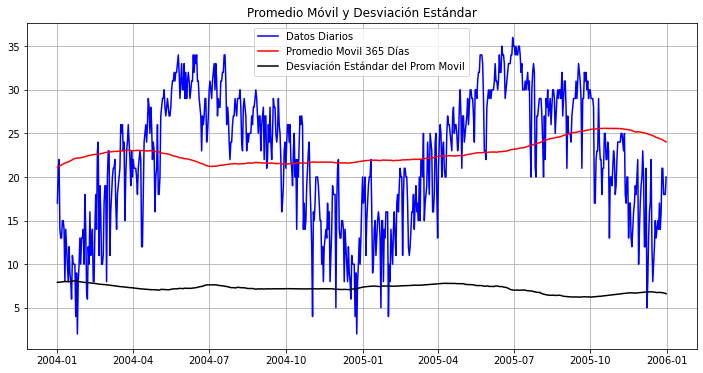

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -2.238709
p-value                             0.192497
#Lag's usados                       8.000000
Número de observaciones usadas    722.000000
Critical Value (1%)                -3.439440
Critical Value (5%)                -2.865551
Critical Value (10%)               -2.568906
dtype: float64


In [5]:
# Primero para el caso de Tmax
# El unico periodo sin huecos es del 2004 al 20005 , para el caso de la temperatura máxima
df_max=df_muestra.loc["2004":"2005","Tmax"].copy()

#Se realiza la prueba:
prueba_est(df_max)


Vemos que p es mucho mayor que 0.05 por lo que no podemos concluir que la serie es estacionaria.
Se procede a realizar trucos para que esto sea así.

La tendencia y la estacionalidad hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la Tendencia sea constante.

Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.

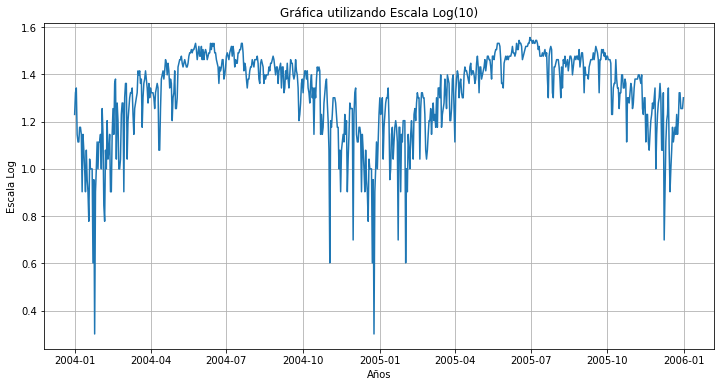

In [6]:
# Trataremos primero con el logaritmo base 10 de los datos (en el eje y)
df_max_log=np.log10(df_max)
plt.plot(df_max_log)
plt.xlabel('Años')
plt.ylabel('Escala Log')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show()


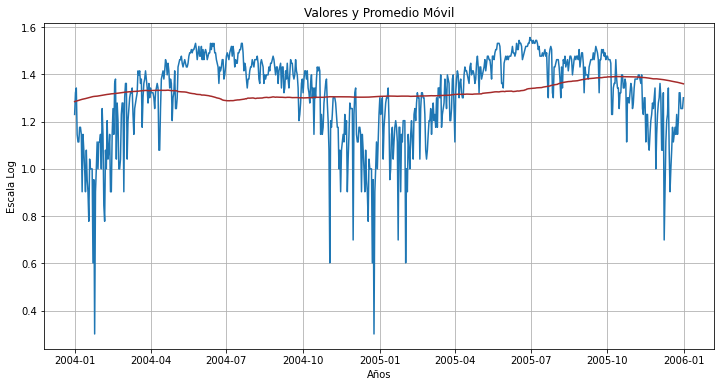

In [7]:
prom_movil_log=df_max_log.rolling(window=365, center=True, min_periods=1).mean()
plt.plot(df_max_log)
plt.plot(prom_movil_log, color="brown", label="Promedio Movil",)
plt.xlabel('Años')
plt.ylabel('Escala Log')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show()

In [8]:
# Definimos una serie a la que se le resta el promedio movil para ponerla en el eje x
df_max_log_mean_dif=df_max_log-prom_movil_log
print(df_max_log_mean_dif.head())

Fecha
2004-01-01   -0.054330
2004-01-02    0.036318
2004-01-03    0.055488
2004-01-04   -0.141750
2004-01-05   -0.175023
Name: Tmax, dtype: float64


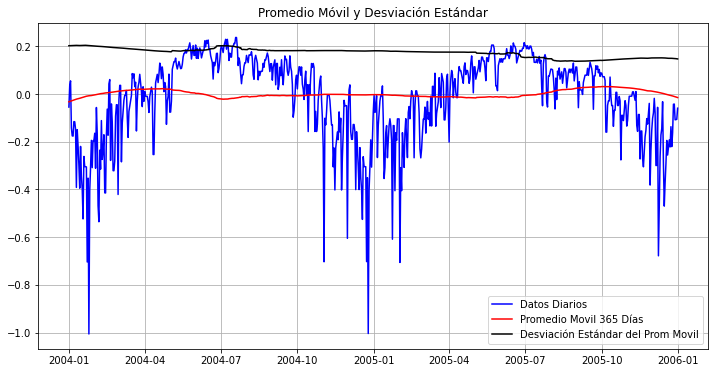

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -2.510108
p-value                             0.113034
#Lag's usados                       8.000000
Número de observaciones usadas    722.000000
Critical Value (1%)                -3.439440
Critical Value (5%)                -2.865551
Critical Value (10%)               -2.568906
dtype: float64


In [9]:
# Se prueba la estacionaridad de esta nueva serie:
prueba_est(df_max_log_mean_dif)

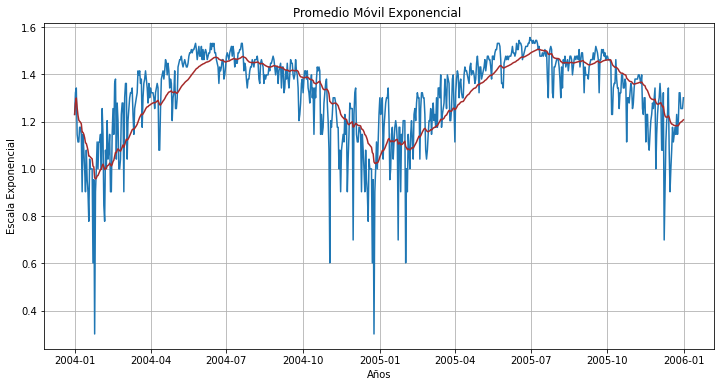

In [10]:
# dado que p>0.05 buscaremos otro forma. Por ejemplo, un promedio exponencial.
# el parámetro 'halflife' representa el número de días que tienen cierta influencia en el promedio, pero su influencia decae exponencialmente.  
exp_prom=df_max_log.ewm(halflife=15).mean()
plt.plot(df_max_log)
plt.plot(exp_prom, color="brown")
plt.xlabel('Años')
plt.ylabel('Escala Exponencial')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show()


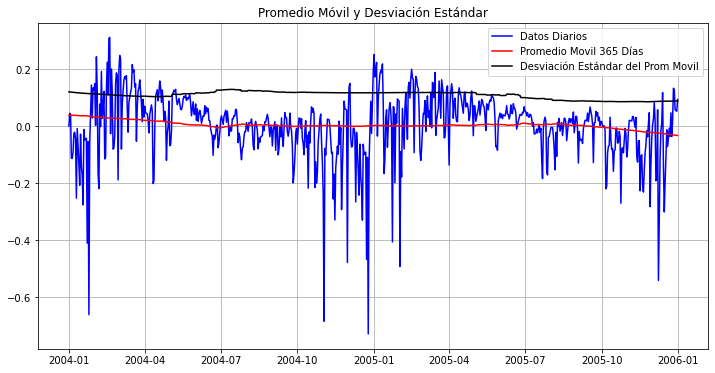

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -4.895321
p-value                             0.000036
#Lag's usados                       8.000000
Número de observaciones usadas    722.000000
Critical Value (1%)                -3.439440
Critical Value (5%)                -2.865551
Critical Value (10%)               -2.568906
dtype: float64


In [11]:
# Nuevamente para bajar al eje x los datos y probar ahi la estacionaridad
df_max_log_exp_dif= df_max_log-exp_prom

prueba_est(df_max_log_exp_dif)

Tenemos ahora un valor para p menor a 0.05. Por tanto se puede concluir que es estacionaria.

Hagamos ahora lo propio para la temperatura mínima:

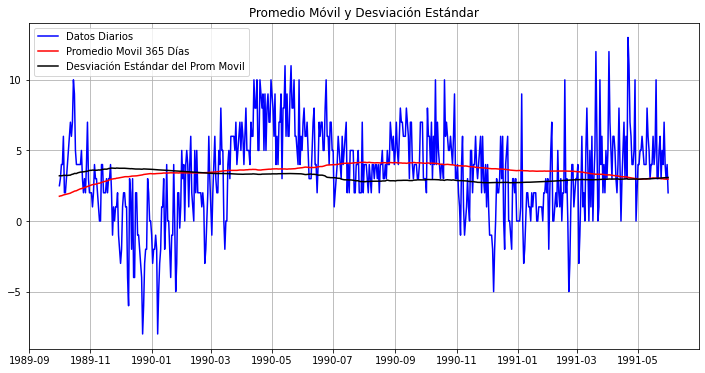

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -2.334291
p-value                             0.161147
#Lag's usados                      13.000000
Número de observaciones usadas    594.000000
Critical Value (1%)                -3.441407
Critical Value (5%)                -2.866418
Critical Value (10%)               -2.569368
dtype: float64


In [12]:
# Definiendo el mayor intervalo sin huecos
df_min=df_muestra.loc["10-01-1989":"05-31-1991","Tmin"].copy()

# Probando estacionaridad
prueba_est(df_min)


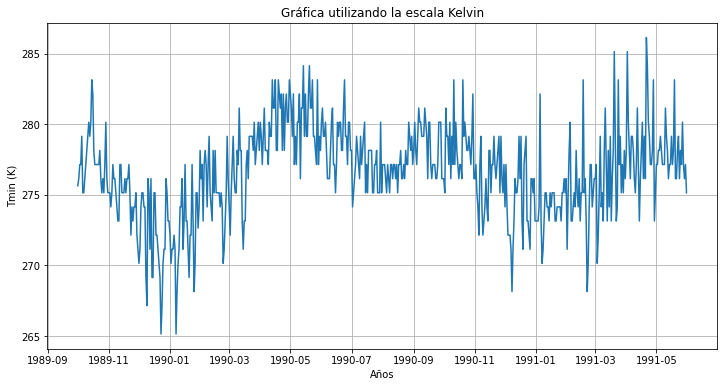

In [13]:
# Puestp que no podemos afirmar que sea estacionaria tendremos que tratarla, primero tomando el log:
# Dado que no se podrá calcular el log de las t negativas tomaremos la escala Kelvin:
df_min_K = df_min + 273.15

plt.plot(df_min_K)
plt.xlabel('Años')
plt.ylabel('Tmin (K)')
plt.title('Gráfica utilizando la escala Kelvin')
plt.grid()
plt.show()


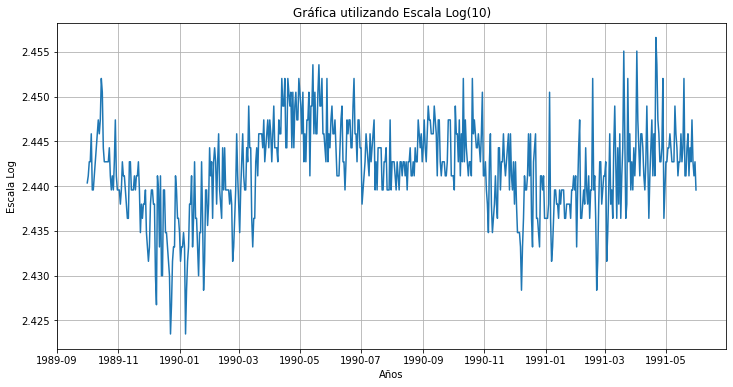

In [14]:
# Tomemos, ahora sí, el logaritmo base 10:
df_min_K_log = np.log10(df_min_K)

plt.plot(df_min_K_log)
plt.xlabel('Años')
plt.ylabel('Escala Log')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show()

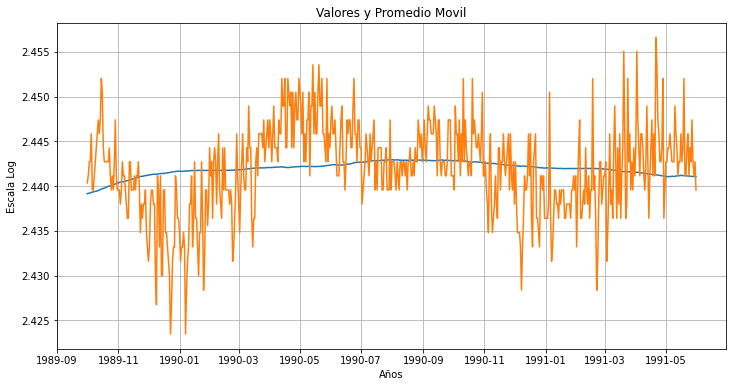

In [15]:
# Encontremos el prom movil:
df_min_K_log_prom=df_min_K_log.rolling(365, center=True, min_periods=1).mean()
plt.plot(df_min_K_log_prom)
plt.plot(df_min_K_log)
plt.xlabel('Años')
plt.ylabel('Escala Log')
plt.title('Valores y Promedio Movil')
plt.grid()
plt.show()

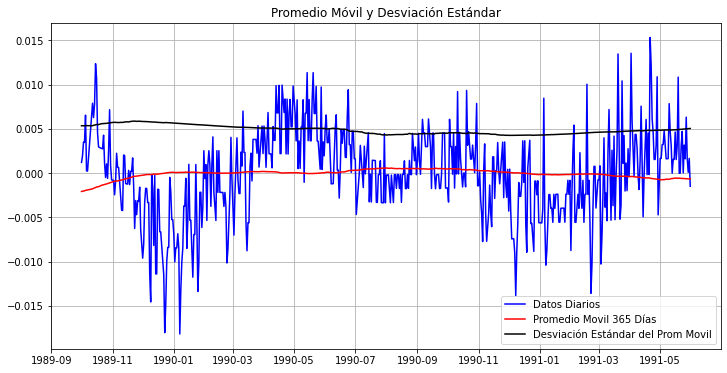

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -2.566428
p-value                             0.100136
#Lag's usados                      13.000000
Número de observaciones usadas    594.000000
Critical Value (1%)                -3.441407
Critical Value (5%)                -2.866418
Critical Value (10%)               -2.569368
dtype: float64


In [16]:
df_min_K_log_prom_dif=df_min_K_log-df_min_K_log_prom

prueba_est(df_min_K_log_prom_dif)


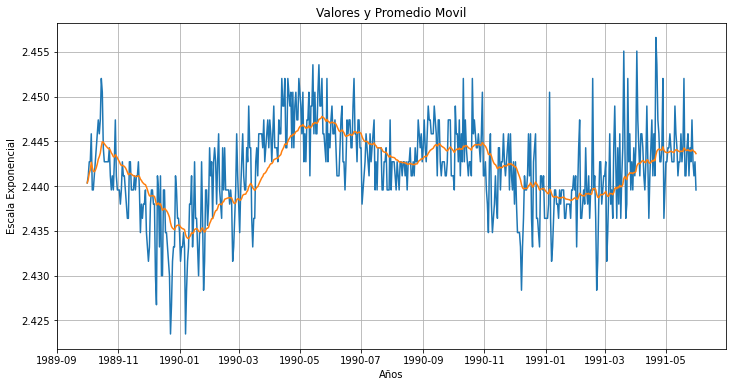

In [17]:
# Como aun no cumplimos con p<0.05 tratemos con promedio exponencial:
exp_min=df_min_K_log.ewm(halflife=15).mean()
plt.plot(df_min_K_log)
plt.plot(exp_min)
plt.xlabel('Años')
plt.ylabel('Escala Exponencial')
plt.title('Valores y Promedio Movil')
plt.grid()
plt.show()

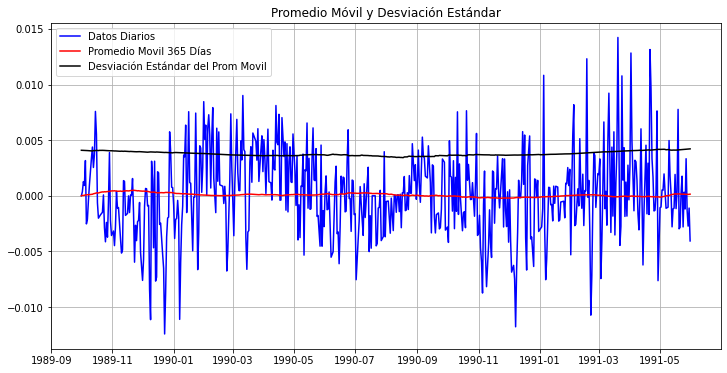

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                    -4.111983
p-value                             0.000925
#Lag's usados                      13.000000
Número de observaciones usadas    594.000000
Critical Value (1%)                -3.441407
Critical Value (5%)                -2.866418
Critical Value (10%)               -2.569368
dtype: float64


In [18]:
# Tomando la diferencia y haciendo la prueba
df_min_K_exp_dif=df_min_K_log-exp_min

prueba_est(df_min_K_exp_dif)

In [19]:
# Dado que p<0.05 podemos proceder.
# Empero usaremos otro metodo, uno que trata de eliminar la estacionalidad de la serie.
# Se trata de la diferenciación.

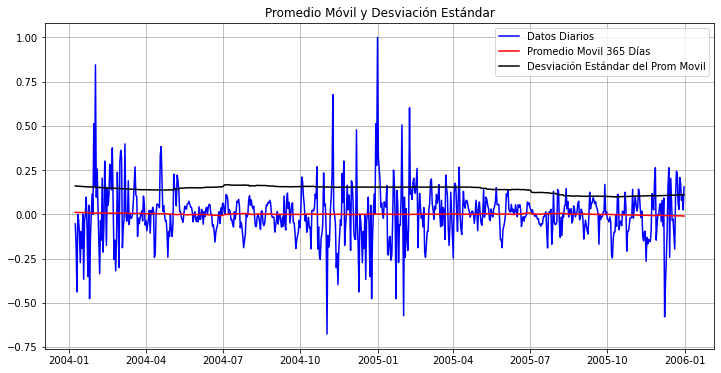

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                  -8.546945e+00
p-value                           9.447046e-14
#Lag's usados                     2.000000e+01
Número de observaciones usadas    7.030000e+02
Critical Value (1%)              -3.439686e+00
Critical Value (5%)              -2.865660e+00
Critical Value (10%)             -2.568964e+00
dtype: float64


In [28]:
df_max_log_diff=df_max_log-df_max_log.shift(periods=7)
df_max_log_diff.dropna(inplace=True)
df_maxp=df_max_log_diff
prueba_est(df_maxp)

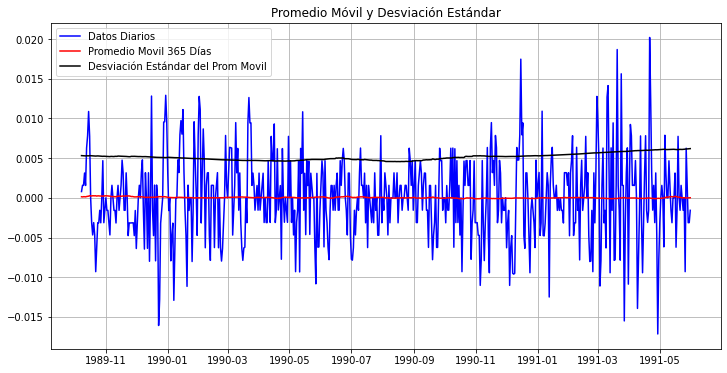

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                  -8.062042e+00
p-value                           1.633145e-12
#Lag's usados                     1.400000e+01
Número de observaciones usadas    5.860000e+02
Critical Value (1%)              -3.441558e+00
Critical Value (5%)              -2.866485e+00
Critical Value (10%)             -2.569403e+00
dtype: float64


In [30]:
df_min_K_log_diff=df_min_K_log-df_min_K_log.shift(periods=7)
df_min_K_log_diff.dropna(inplace=True)
df_minp = df_min_K_log_diff
prueba_est(df_minp)


# **Pronostico de las Series de Tiempo**

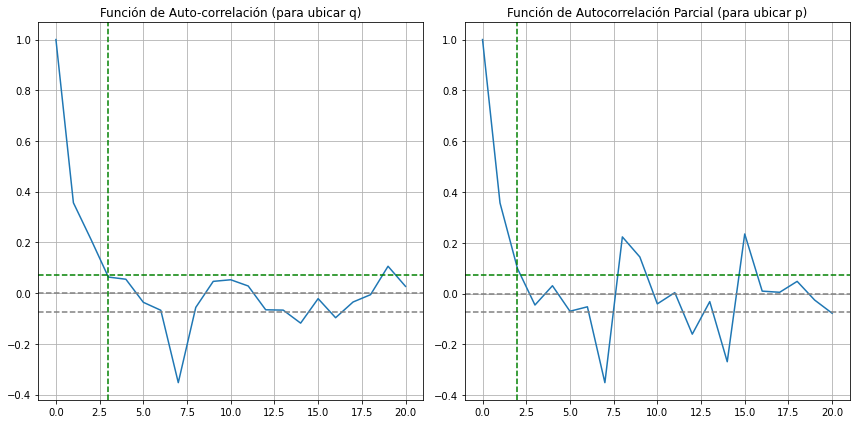

In [21]:
# Se renombraron las series de Tmin y Tmax estacionarias a df_minp y df_maxp respectivamente.
# Con las series de tiempo estacionarias listas se puede dar paso a utilizar el metodo Arima
# Primero para Tmax
lag_acf=acf(df_maxp, nlags=20)
lag_pacf=pacf(df_maxp, nlags=20, method="ols")

# Tamaño para las graficas:
plt.rcParams["figure.figsize"]=(12,6)

# Grafica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(df_maxp)), linestyle="--", color= "gray")
plt.axhline(y=1.96/np.sqrt(len(df_maxp)), linestyle="--", color="green")

# Lineas verticales para ayudar a visualizar el valor de q
plt.axvline(x=3, linestyle="--", color="green")
plt.grid()
plt.title("Función de Auto-correlación (para ubicar q)")

# Grafica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_maxp)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_maxp)), linestyle='--', color='green')
# Referencia vertical
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title("Función de Autocorrelación Parcial (para ubicar p)")

plt.tight_layout()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  730
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 595.534
Method:                       css-mle   S.D. of innovations              0.107
Date:                Thu, 25 Feb 2021   AIC                          -1183.069
Time:                        01:16:31   BIC                          -1164.697
Sample:                    01-02-2004   HQIC                         -1175.981
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.272e-05      0.002      0.009      0.993      -0.005       0.005
ar.L1.D.Tmax    -0.4440      0.037    -12.158      0.000      -0.516      -0.372
ar.L2.D.Tmax    -0.1633      0.036     -4.47

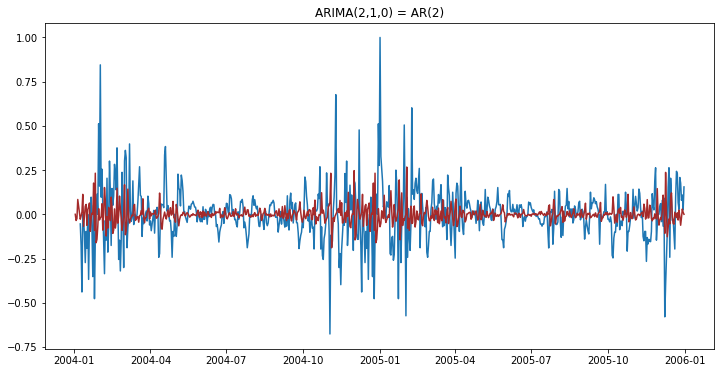

In [22]:
# Aplicamos ahora el Modelo AR (p,d,q)
model = ARIMA(df_max_log, order=(2,1,0), missing="drop")
results_AR = model.fit(displ=-1)
plt.plot(df_maxp)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  730
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 638.692
Method:                       css-mle   S.D. of innovations              0.101
Date:                Thu, 25 Feb 2021   AIC                          -1267.383
Time:                        01:16:31   BIC                          -1244.418
Sample:                    01-02-2004   HQIC                         -1258.523
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.001      0.131      0.896      -0.001       0.002
ma.L1.D.Tmax    -0.5703      0.037    -15.463      0.000      -0.643      -0.498
ma.L2.D.Tmax    -0.0842      0.041     -2.03

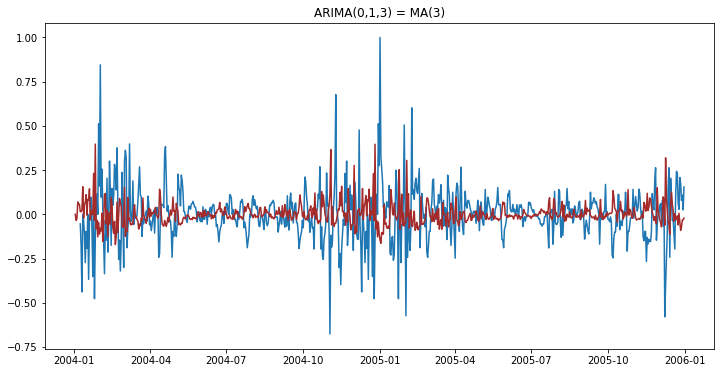

In [23]:
# Toca ahora el Modelo MA(q): (p,d,q) = (0,1,3) 
model = ARIMA(df_max_log, order=(0,1,3), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(df_maxp)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,3) = MA(3)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  730
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 639.247
Method:                       css-mle   S.D. of innovations              0.101
Date:                Thu, 25 Feb 2021   AIC                          -1264.494
Time:                        01:16:32   BIC                          -1232.343
Sample:                    01-02-2004   HQIC                         -1252.090
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.001      0.133      0.894      -0.001       0.002
ar.L1.D.Tmax    -0.3215      0.218     -1.478      0.140      -0.748       0.105
ar.L2.D.Tmax     0.1656      0.151      1.09

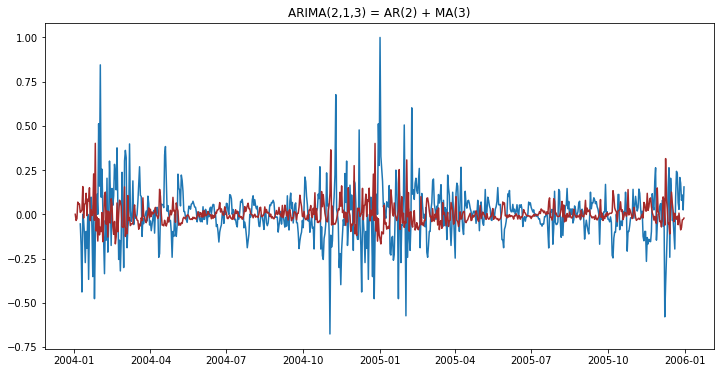

In [24]:
# Modelo ARIMA(p): (p,d,q) = (2,1,3) 
model = ARIMA(df_max_log, order=(2,1,3), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(df_maxp)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,3) = AR(2) + MA(3)')
print(results_ARIMA.summary())

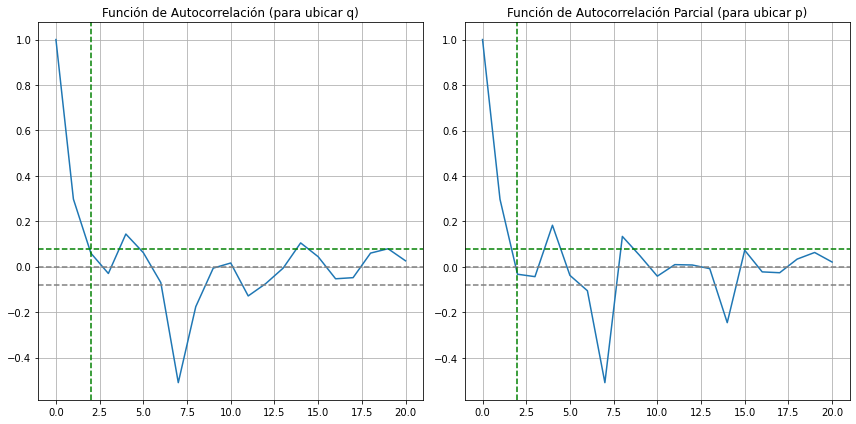

In [37]:
# Se ve que la mejor opción es el modelo MA, por lo que para Tmax estará será nuestra opción.
# Es procede a hacer lo propio con Tmin

lag_acf = acf(df_minp, nlags=20)
lag_pacf = pacf(df_minp, nlags=20, method="ols")

# Tamaño de la figura
plt.rcParams["figure.figsize"]=(12,6)

# Grafica ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(-1.96/np.sqrt(len(df_minp)), color="gray", linestyle="--")
plt.axhline(1.96/np.sqrt(len(df_minp)), color="green", linestyle="--")
plt.axhline(y=0, color="gray", linestyle="--")
# Lineas de referencia para ubicar q
plt.axvline(x=2, color="green", linestyle="--")
plt.grid()
plt.title("Función de Autocorrelación (para ubicar q)");

# Grafica PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, color="gray", linestyle="--")
plt.axhline(1.96/np.sqrt(len(df_minp)), color="green", linestyle="--")
plt.axhline(-1.96/np.sqrt(len(df_minp)), color="gray", linestyle="--")
# Referencia para ubicar p
plt.axvline(x=2, color="green", linestyle="--")
plt.grid()
plt.title("Función de Autocorrelación Parcial (para ubicar p)")

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                  607
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2502.191
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 25 Feb 2021   AIC                          -4996.381
Time:                        01:52:20   BIC                          -4978.747
Sample:                    10-02-1989   HQIC                         -4989.520
                         - 05-31-1991                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.571e-07   9.97e-05     -0.006      0.996      -0.000       0.000
ar.L1.D.Tmin    -0.3794      0.040     -9.581      0.000      -0.457      -0.302
ar.L2.D.Tmin    -0.2177      0.040     -5.50

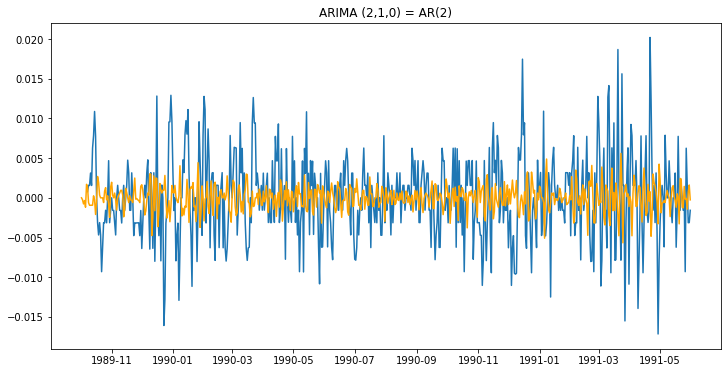

In [42]:
# Por observación tomaremos a q como 2 y a p como 2
# p=2, q=2
# Con dichos valores podemos proceder a aplicar ARIMA(p,d,q)
# Primero el modelo AR(p)
model = ARIMA(df_min_K_log, order=(2,1,0), missing="drop")
results_AR_min=model.fit(displ=-1)
plt.plot(df_minp)
plt.plot(results_AR_min.fittedvalues, color="orange")
plt.title("ARIMA (2,1,0) = AR(2)")
print(results_AR_min.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                  607
Model:                 ARIMA(0, 1, 2)   Log Likelihood                2556.636
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 25 Feb 2021   AIC                          -5105.272
Time:                        01:52:32   BIC                          -5087.637
Sample:                    10-02-1989   HQIC                         -5098.410
                         - 05-31-1991                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.454e-07   2.23e-05      0.020      0.984   -4.33e-05    4.42e-05
ma.L1.D.Tmin    -0.6131      0.036    -16.855      0.000      -0.684      -0.542
ma.L2.D.Tmin    -0.2351      0.035     -6.68

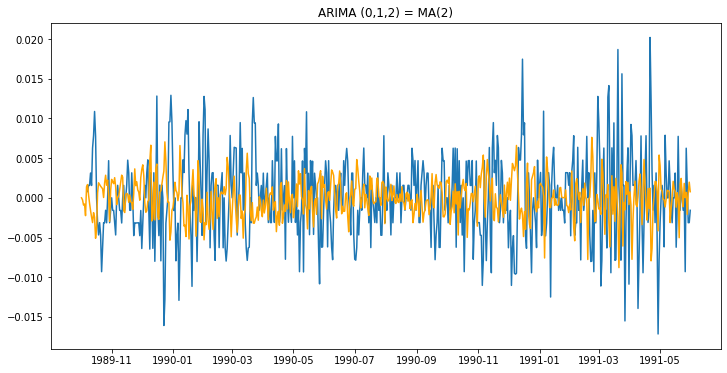

In [43]:
# Ahora el Modelo MA(q)
model = ARIMA(df_min_K_log, order=(0,1,2), missing="drop")
results_MA_min = model.fit(displ=-1)
plt.plot(df_minp)
plt.plot(results_MA_min.fittedvalues, color="orange")
plt.title("ARIMA (0,1,2) = MA(2)")
print(results_MA_min.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                  607
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2558.526
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 25 Feb 2021   AIC                          -5105.051
Time:                        01:53:43   BIC                          -5078.600
Sample:                    10-02-1989   HQIC                         -5094.760
                         - 05-31-1991                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.742e-07   2.11e-05      0.027      0.978   -4.07e-05    4.18e-05
ar.L1.D.Tmin    -0.6029      0.107     -5.630      0.000      -0.813      -0.393
ar.L2.D.Tmin     0.2981      0.047      6.31

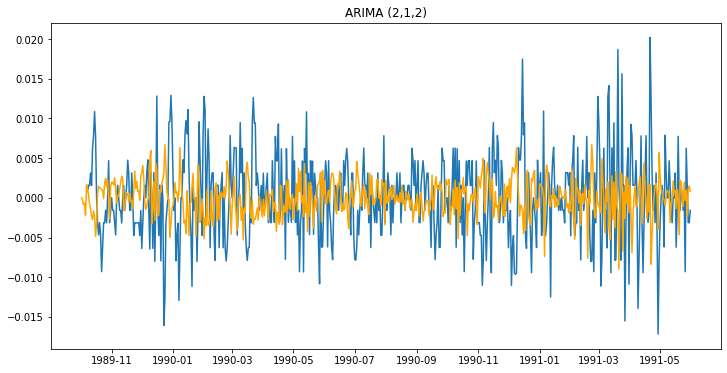

In [44]:
# ARIMA COMPLETO
model= ARIMA(df_min_K_log, order=(2,1,2), missing="drop")
results_ARIMA_min=model.fit(displ=-1)
plt.plot(df_minp)
plt.plot(results_ARIMA_min.fittedvalues, color="orange")
plt.title("ARIMA (2,1,2)")
print(results_ARIMA_min.summary())



In [45]:
# Nuevamente el mejor modelo es MA(2), por tener el menor AIC con una minima diferencia con el ARIMA(2,1,2)
# Ahora definimos una serie de tiempo para Tmax con las predicciones obtenidas de MA(3)

predi_tmax_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predi_tmax_diff)

Fecha
2004-01-02    0.000103
2004-01-03   -0.034552
2004-01-04   -0.024565
2004-01-05    0.070136
2004-01-06    0.055993
                ...   
2005-12-27   -0.091304
2005-12-28   -0.072427
2005-12-29   -0.032406
2005-12-30   -0.031349
2005-12-31   -0.021254
Length: 730, dtype: float64


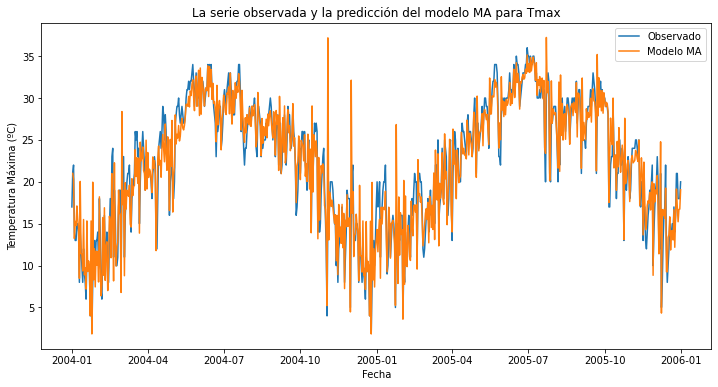

In [48]:
# Sumamos las predicciones de ARIMA
predi_tmax_log = pd.Series(df_max_log, index=df_max_log.index)
predi_tmax_log = predi_tmax_log.add(predi_tmax_diff)

# Ahora tomemos el antilogaritmo 10**Tmax
predi_tmax = 10**(predi_tmax_log)

# Graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_max, label="Observado");
plt.plot(predi_tmax, label="Modelo MA");
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('La serie observada y la predicción del modelo MA para Tmax')
plt.legend(loc='best');

In [49]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predi_tmax - df_max)**2))
print('RMSE:', RMSE)

RMSE: 2.452822594119116


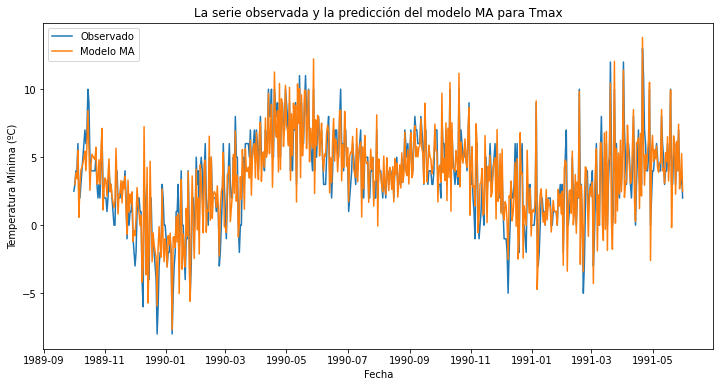

In [50]:
# Para el caso de Tmin:
predi_tmin_diff = pd.Series(results_MA_min.fittedvalues, copy=True)

# Sumamos a la serie en escala de logaritmo las predicciones de ARIMA

predi_tmin_K_log = pd.Series(df_min_K_log, index=df_min_K_log.index)
predi_tmin_K_log = predi_tmin_K_log.add(predi_tmin_diff)

# Tomemos el antilogaritmo
predi_tmin_K = 10**(predi_tmin_K_log)

# Volvemos a celcius
predi_tmin = predi_tmin_K - 273.15

# Graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_min, label="Observado");
plt.plot(predi_tmin, label="Modelo MA");
plt.xlabel('Fecha')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('La serie observada y la predicción del modelo MA para Tmax')
plt.legend(loc='best');

In [51]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predi_tmin - df_min)**2))
print('RMSE:', RMSE)

RMSE: 1.5000934678354951
